In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import os
import random
import time
!pip install ase
from ase import io
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!pip install megnet

from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

!pip install monty
from monty.json import MontyDecoder
from monty.serialization import loadfn

from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

!pip install --pre dgl -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install alignn

!git clone https://github.com/bvd757/3DSC.git

!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/bvd757/alignn

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

#!pip install dgl-cu111 # Colab has cuda 11.1

import pymatgen as mg
import json
import re
import matplotlib

from sklearn.metrics import mean_squared_error as mse

font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
from alignn.models.alignn import ALIGNN, ALIGNNConfig
from alignn.data import get_torch_dataset
from torch.utils.data import DataLoader
import tempfile
import torch
import sys

# from jarvis.db.jsonutils import loadjson
import argparse
from jarvis.core.atoms import Atoms
from jarvis.core.graphs import Graph
from jarvis.db.jsonutils import dumpjson

In [ ]:
#@title Load data
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data1 = data.loc[data['tc'] > 0.1]
#data1 = data1.loc[data['tc'] < 30.0]
data_t = np.log(data1[['tc']])
data2 = data1[['formula_sc']]

from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data2)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

StrToComposition:   0%|          | 0/3950 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3950 [00:00<?, ?it/s]

In [ ]:
#@title Good and Bad cifs
!rm -r /content/GOOD_CIFs
!rm -r /content/BAD_CIFs

!mkdir /content/GOOD_CIFs
!mkdir /content/BAD_CIFs

targets1 = [0] * len(df)
names1 = [0] * len(df)

for i, cif in enumerate(os.listdir(path='/content/3DSC/superconductors_3D/data/final/MP/cifs')):
    with open('/content/3DSC/superconductors_3D/data/final/MP/cifs/' + cif) as f:
        lines = f.readlines()
    lines.reverse()
    
    occupancies = []
    
    for line in lines:
        if line != ' _atom_site_occupancy\n':
            occupancies.append(line.split()[-1])
        else:
            break
            
    l = set(occupancies)
    
    if len(l) != 1:
        #print(cif)
        os.system('cp /content/3DSC/superconductors_3D/data/final/MP/cifs/' + cif + ' /content/BAD_CIFs')
    else:
        if cif[:cif.find('-MP')] not in df['element'].to_list(): continue
        j = df.loc[df['element'] == cif[:cif.find('-MP')]].index
        k = data1.loc[data1['formula_sc'] == cif[:cif.find('-MP')]].index
        j = j[0]
        k = k[0]
        targets1[j] = data_t.loc[k]['tc']
        names1[j] = cif
        os.system('cp /content/3DSC/superconductors_3D/data/final/MP/cifs/' + cif + ' /content/GOOD_CIFs')

names2 = []
targets2 = []
for i in range(len(targets1)):
    if names1[i] != 0 and targets1[i] != 0:
        names2.append(names1[i][:-4]+'.vasp')
        targets2.append(targets1[i])

print("Размер датасета:", len(targets2))

Размер датасета: 1234


In [ ]:
#@title Good cifs in vasp
!rm -r /content/GOOD_CIFs_vasp
!mkdir /content/GOOD_CIFs_vasp
for i, cif in enumerate(os.listdir(path='/content/GOOD_CIFs')):
    try:
        atoms = io.read('/content/GOOD_CIFs/' + cif)
        t = "/content/GOOD_CIFs_vasp/" + cif[:-4] + ".vasp"
        atoms.write(t, format = 'vasp')
    except:
        print(1)
        continue

In [ ]:
#@title Functions
device = "cpu"

def get_all_models():
    """Return the figshare links for models."""
    return all_models


def get_figshare_model(model_name="jv_formation_energy_peratom_alignn"):
    """Get ALIGNN torch models from figshare."""
    
    model = ALIGNN(
        ALIGNNConfig(name="alignn", output_features=1)
    )
    
    model.load_state_dict(torch.load(model_name, map_location=device)["model"])
    model.to(device)
    model.eval()

    return model


def get_prediction(
    model_name="jv_formation_energy_peratom_alignn",
    atoms=None,
    cutoff=8,
):
    """Get model prediction on a single structure."""
    model = get_figshare_model(model_name)
    # print("Loading completed.")
    g, lg = Graph.atom_dgl_multigraph(atoms, cutoff=float(cutoff))
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    return out_data[0]

def plot1(predictions, test_label, modeltype, alpha = 0.1):
    def mse(predictions, test_label):
        predictions = np.array(predictions)
        y_test = np.array(test_label)
        return round(((predictions - test_label) ** 2).mean(), 4)

    fig, ax = plt.subplots()
    ax.grid()
    plt.grid()
    plt.scatter(test_label, predictions, color = 'red', marker='^', s = 200,  alpha = alpha)
    plt.plot(test_label, test_label, color = 'black', linewidth = 3, alpha = 0.1)
    plt.text(3.5, 2.5 ,"mse = " + str(mse(test_label, predictions)) , fontsize=10, bbox={'facecolor':'yellow','alpha':0.2})
    plt.xlabel('measured $ln T_c$')
    plt.ylabel('predicted $ln T_c$')
    plt.title(modeltype)
    #plt.ylim((0, 4))
    plt.show()

In [ ]:
#@title Train/Test + Id Prop

names_train = []
names_test = []
targets_train = []
targets_test = []
for i in range(len(names2)):
    if random.randint(0, 5) == 1:
        names_test.append(names2[i])
        targets_test.append(targets2[i])
    else:
        names_train.append(names2[i])
        targets_train.append(targets2[i])

id_prop = pd.DataFrame({names_train[0]: names_train, targets_train[0]: targets_train})
id_prop.to_csv(r'/content/GOOD_CIFs_vasp/id_prop.csv', index= False)
pd.read_csv("/content/GOOD_CIFs_vasp/id_prop.csv")

,Ag0.5Ba1Si1.5-MP-mp-9867.vasp,0.1906203596086497
0,Ag0.5Ba1Si1.5-MP-mp-9867.vasp,0.190620
1,Ag0.5Pd0.5Th2-MP-mp-1217282.vasp,0.182322
2,Ag1B2-MP-mp-12062.vasp,1.902108
3,Ag1In2-MP-mp-760385.vasp,0.854415
4,Ag1Mo6S8-MP-mp-35109.vasp,2.041220
...,...,...
1035,U1-MP-mp-44.vasp,-0.541858
1036,V2Zr1-MP-mp-1103264.vasp,2.196484
1037,V3Zr3O1-MP-mp-504834.vasp,2.014903
1038,Zn1-MP-mp-79.vasp,-0.161578


In [ ]:
#@title Train
import time
t1=time.time()
!train_folder.py --root_dir "/content/GOOD_CIFs_vasp" --epochs 50 --batch_size 1 --config "alignn/examples/sample_data/config_example.json" --file_format poscar --output_dir=temp
t2=time.time()
print ('Time in s',t2-t1)

Text(0, 0.5, 'MAE')

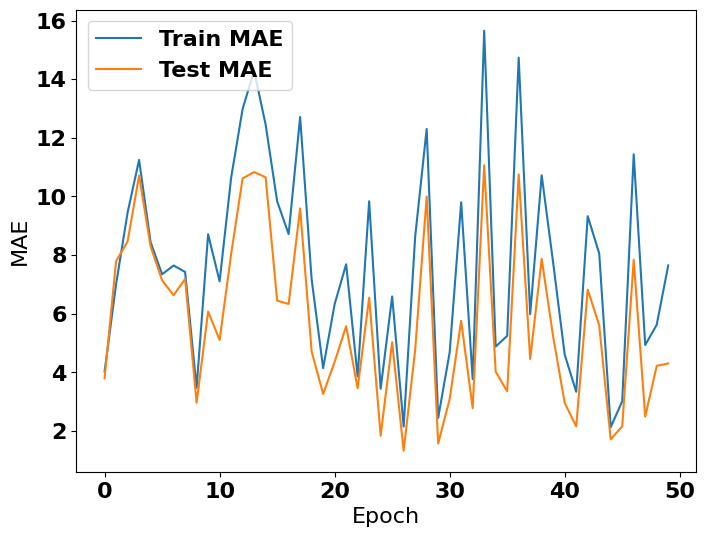

In [ ]:
#@title Learning curve
shg_train = pd.read_json('/content/alignn/temp/history_train.json')
shg_val = pd.read_json('/content/alignn/temp/history_val.json')

fig = plt.figure(figsize=(8,6))
plt.plot(shg_train['mae'], label='Train MAE')
plt.plot(shg_val['mae'], label='Test MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')

In [ ]:
#@title Get predictions
#model_name = '/content/alignn/temp/checkpoint_50.pt'
model_name = '/content/models/checkpoint_50.pt'
preds_test = []
for i, cif in enumerate(names_test):
    atoms = Atoms.from_poscar('/content/GOOD_CIFs_vasp/' + cif)
    preds_test.append(get_prediction(
        model_name=model_name,
        atoms=atoms,
        cutoff=8))
    

preds_train = []
for i, cif in enumerate(names_train):
    atoms = Atoms.from_poscar('/content/GOOD_CIFs_vasp/' + cif)
    preds_train.append(get_prediction(
        model_name=model_name,
        atoms=atoms,
        cutoff=8))

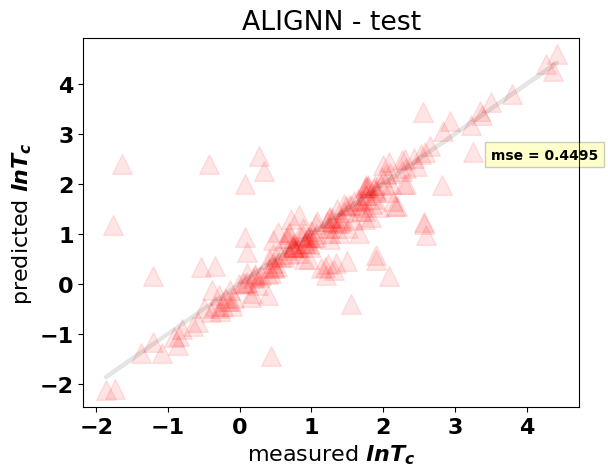

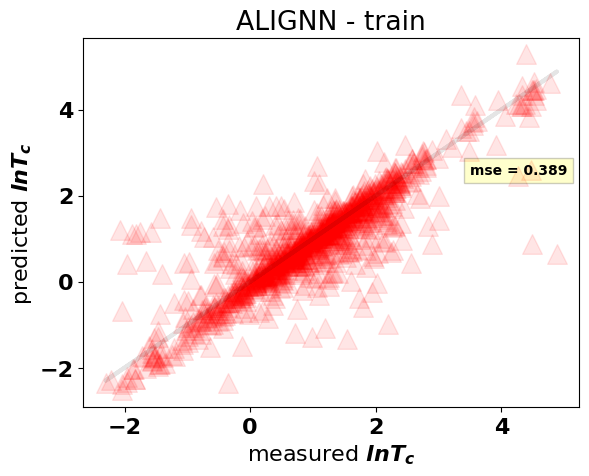

In [ ]:
#@title Plots
plot1(predictions = preds_test, test_label = targets_test, modeltype = 'ALIGNN - test', alpha = 0.1)
plot1(predictions = preds_train, test_label = targets_train, modeltype = 'ALIGNN - train')

104/104 [==============================] - 15s 148ms/step - loss: 0.0178
Epoch 50/50
104/104 [==============================] - 16s 152ms/step - loss: 0.0171


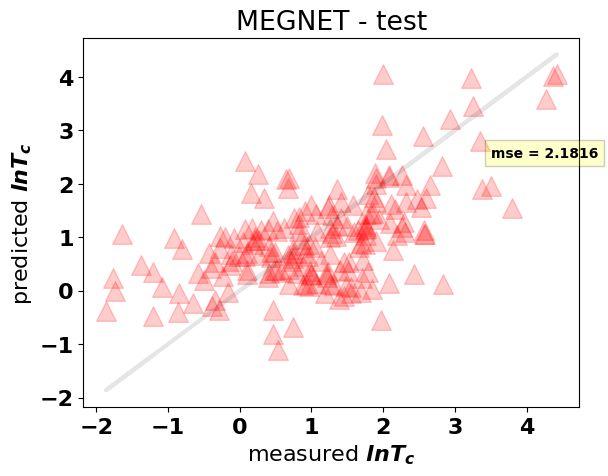

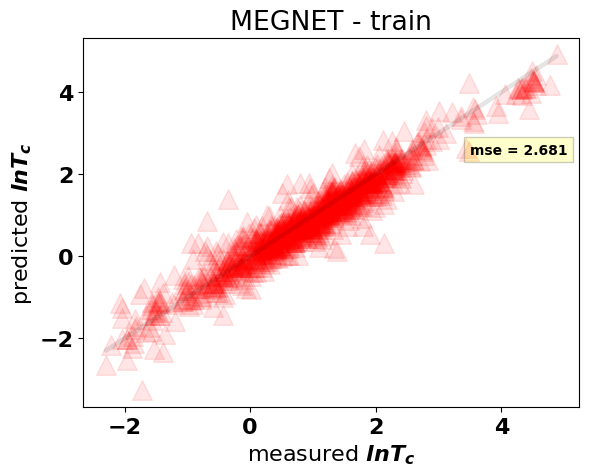

In [ ]:
#@title Megnet
from megnet.utils.models import load_model, AVAILABLE_MODELS
from pymatgen.core import Structure, Lattice
from pymatgen.ext.matproj import MPRester
model = load_model('Efermi_MP_2019')
model.compile(loss='mse')

structures_train = []
for name in names_train:
    structures_train.append(Structure.from_file('/content/GOOD_CIFs_vasp/' + name))

structures_test = []
for name in names_test:
    structures_test.append(Structure.from_file('/content/GOOD_CIFs_vasp/' + name))

model.train(structures_train, targets_train, epochs=50, batch_size = 10,  verbose = 1)

preds_test_megnet = []
for structure in structures_test:
    preds_test_megnet.append(model.predict_structure(structure).ravel())

preds_train_megnet = []
for structure in structures_train:
    preds_train_megnet.append(model.predict_structure(structure).ravel())

plot1(predictions = preds_test_megnet, test_label = targets_test, modeltype = 'MEGNET - test', alpha = 0.2)
plot1(predictions = preds_train_megnet, test_label = targets_train, modeltype = 'MEGNET - train')